In [2]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox


In [3]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
sagemaker_session = sagemaker.Session()

In [5]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-electricity-demo-notebook"  # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [6]:
s3_bucket

'sagemaker-us-east-1-772743166229'

In [7]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [8]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

In [9]:
# Run tomorrow

In [11]:
DATA_HOST = f"sagemaker-example-files-prod-{region}"
DATA_PATH = "datasets/timeseries/uci_electricity/"
ARCHIVE_NAME = "LD2011_2014.txt.zip"
FILE_NAME = ARCHIVE_NAME[:-4]

In [12]:
s3_client = boto3.client("s3")

if not os.path.isfile(FILE_NAME):
    print("downloading dataset (258MB), can take a few minutes depending on your connection")
    s3_client.download_file(DATA_HOST, DATA_PATH + ARCHIVE_NAME, ARCHIVE_NAME)

    print("\nextracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_NAME, "r")
    zip_ref.extractall("./")
    zip_ref.close()
else:
    print("File found skipping download")

File found skipping download


/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [13]:
data = pd.read_csv(FILE_NAME, sep=";", index_col=0, parse_dates=True, decimal=",")
num_timeseries = data.shape[1]
data_kw = data.resample("2H").sum() / 8
# To trim the leading zeros:
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

In [13]:
#rough
# data is a dataframe
# timeseries is a list of series
type(data), type(timeseries)
data.tail()
timeseries[-1]

data.shape # (140256, 370)
data_kw.shape # (17533, 370)
type(data)

pandas.core.frame.DataFrame

In [57]:
# rough
# To view the data use info and describe
#data.info()
data.isnull().sum().sum()  #=0 No Null values
data.head()
data_kw.head()
data_kw.info()
data_kw.iloc[:, 0]
timeseries[369]
## Different timeseries are starting from different dates because the leading
# zeros are removed.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17533 entries, 2011-01-01 00:00:00 to 2015-01-01 00:00:00
Freq: 2H
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 49.6 MB


2013-01-01 00:00:00     6927.027027
2013-01-01 02:00:00     7581.081081
2013-01-01 04:00:00     7491.891892
2013-01-01 06:00:00     7254.054054
2013-01-01 08:00:00     6689.189189
                           ...     
2014-12-31 16:00:00    12033.783784
2014-12-31 18:00:00     9554.054054
2014-12-31 20:00:00     8344.594595
2014-12-31 22:00:00     7263.513514
2015-01-01 00:00:00      891.891892
Freq: 2H, Name: MT_370, Length: 8761, dtype: float64

In [53]:
#rough
np_timeseries = np.array([len(ts) for ts in timeseries])
unique_values, value_counts = np.unique(np_timeseries, return_counts=True)
result = dict(zip(unique_values, value_counts))
print(result)
## There are 41 different lengths of time series. Most of the time series
# have lengths equal to 13153 or 17533. Those having lengths equal to 17533
# means that the length is same as the original having a start date of 
# Jan/2011.

{2005: 1, 3521: 1, 3625: 1, 3805: 2, 3877: 1, 3973: 1, 4189: 1, 4225: 11, 4525: 1, 4657: 1, 4777: 1, 5455: 1, 5540: 1, 5694: 1, 5792: 1, 5869: 1, 5874: 1, 6673: 1, 6709: 1, 6906: 1, 7218: 1, 8065: 1, 8396: 1, 8761: 3, 9306: 1, 9409: 1, 9546: 1, 10339: 1, 10405: 1, 10741: 1, 10789: 1, 10818: 1, 10969: 1, 11077: 1, 12080: 1, 12193: 1, 13073: 1, 13153: 160, 16381: 1, 16904: 1, 17533: 158}


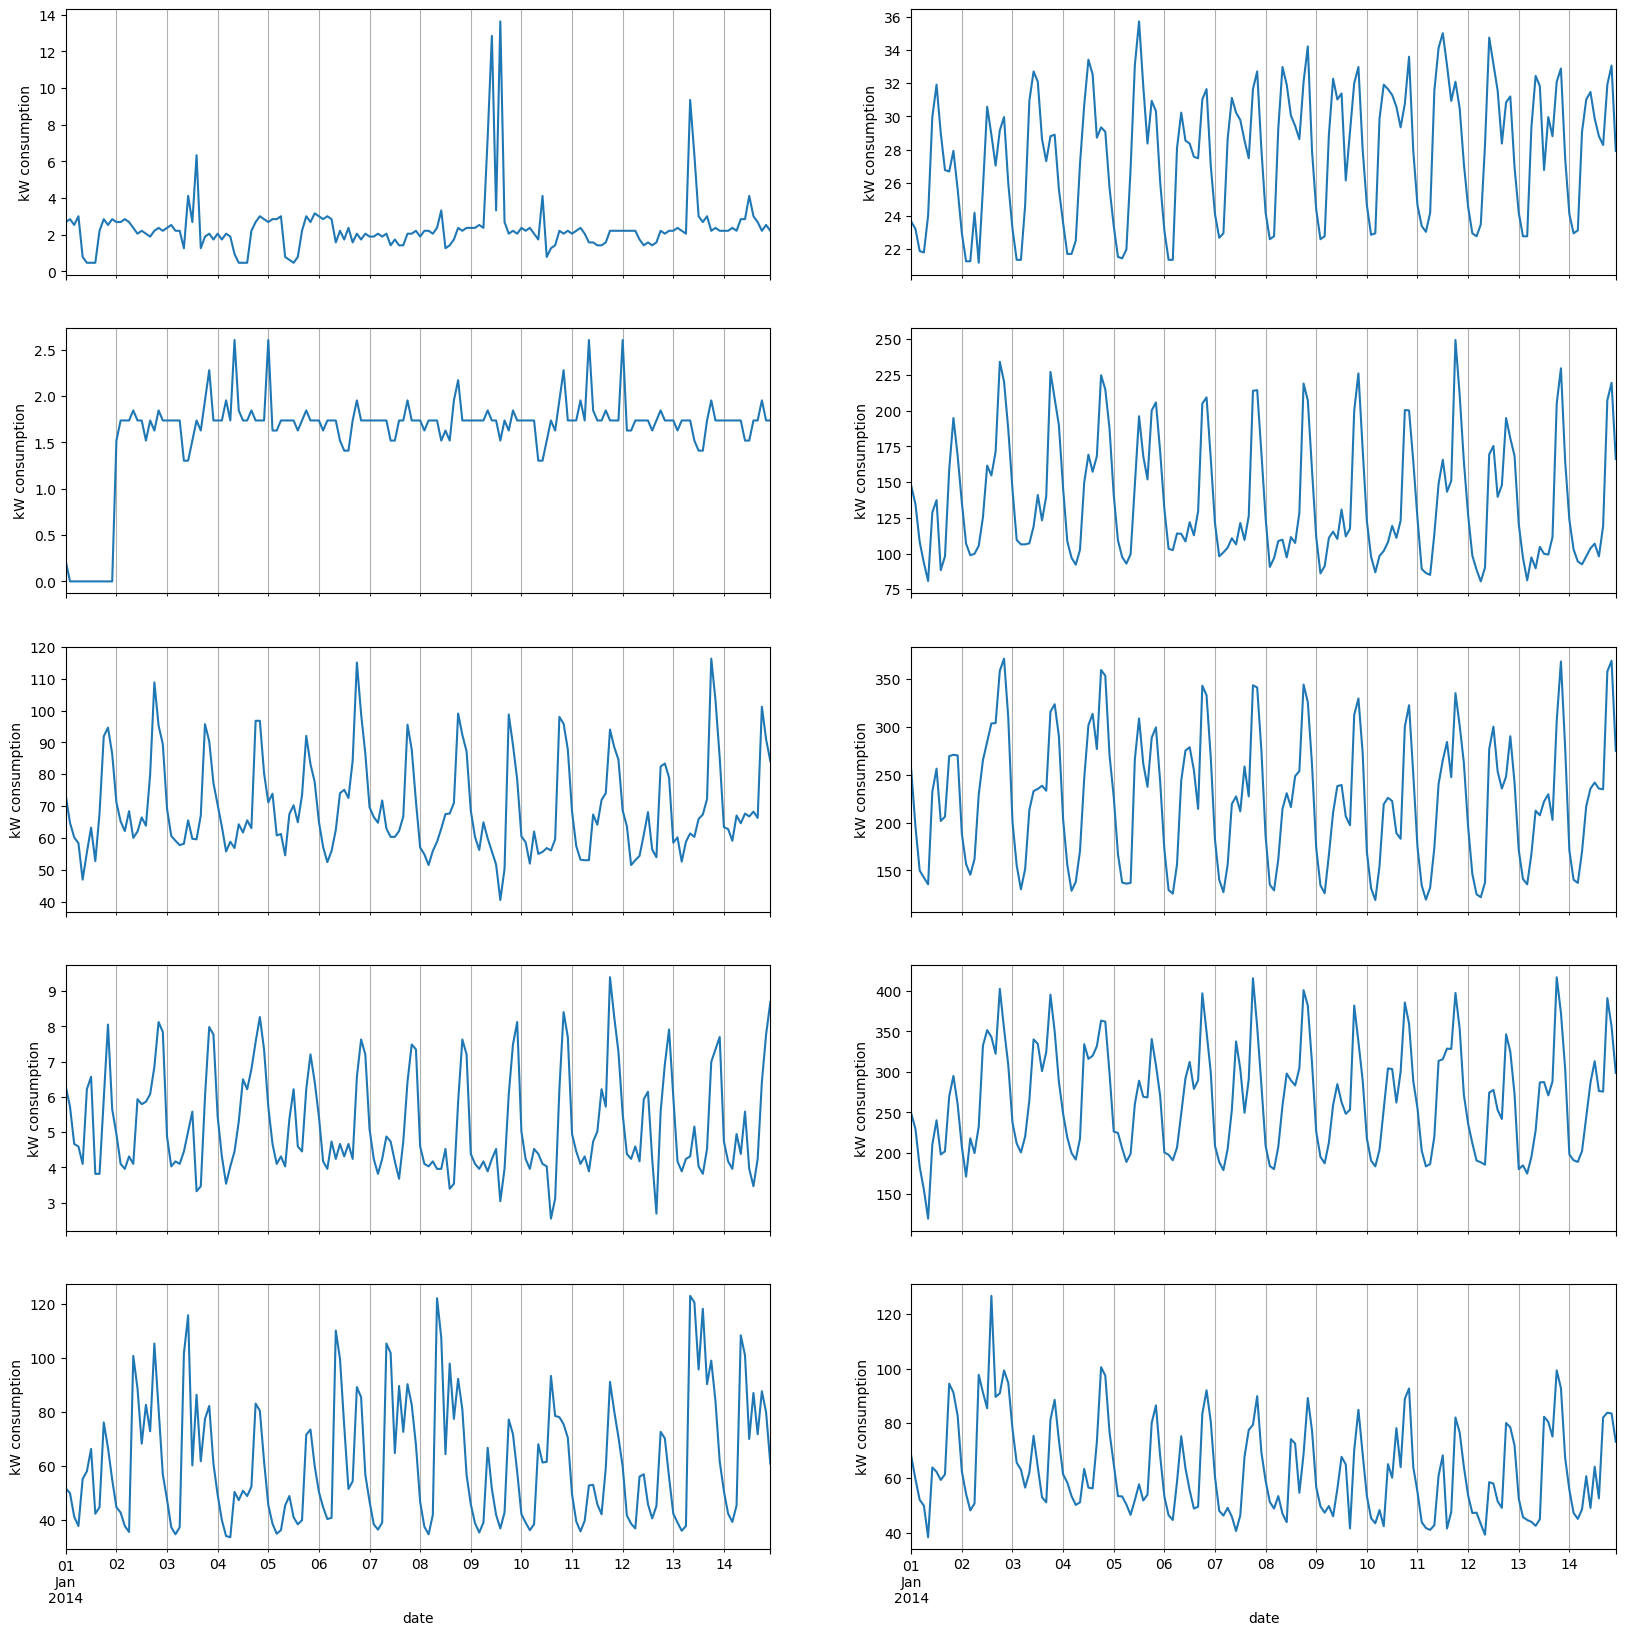

In [58]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2014-01-01":"2014-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("kW consumption")
    axx[i].grid(which="minor", axis="x")

In [14]:
# we use 2 hour frequency for the time series
freq = "2H"

# we predict for 7 days
prediction_length = 7 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12

In [15]:
# These are just two dates, nothing else:
start_dataset = pd.Timestamp("2014-01-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2014-09-01 00:00:00", freq=freq)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # We use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(len(training_data))

370


In [95]:
#rough
len(training_data[369]['target'])
#print(start_dataset, end_training - timedelta(hours=1))
# 2905 is length of each target list

2905

In [96]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries
]
print(len(test_data)) #= 370*4

# I spot a mistake here that the timedelta of prediction length should be based on hours.

1480


In [113]:
# rough - Check length of each target list
#for i in range(0,1500,50):
#    print(len(test_data[i]['target']))
# Reason: see above
# 3925 means ~11 months data
# 4381 means ~12 months data

# So I just want to say that instead of predicting one to four weeks,
# 3 to four months are going to be predicted.

In [25]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [115]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 6.67 s, sys: 108 ms, total: 6.77 s
Wall time: 9.06 s


In [29]:

s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [117]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-1-772743166229/deepar-electricity-demo-notebook/data/train/train.json
Uploading file to s3://sagemaker-us-east-1-772743166229/deepar-electricity-demo-notebook/data/test/test.json
CPU times: user 424 ms, sys: 220 ms, total: 645 ms
Wall time: 1.55 s


In [119]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2014-01-01 00:00:00", "target": [2.696700507614215, 2.85532994923858, 2.53807106598985, 3...


In [132]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.2xlarge",
    base_job_name="deepar-electricity-demo",
    output_path=s3_output_path,
    # By me:
    train_use_spot_instances = True,
    train_max_run = 1800,
    train_max_wait = 1800
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [133]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "100", # Changed by me
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

estimator.set_hyperparameters(**hyperparameters)

In [134]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: deepar-electricity-demo-2023-08-10-13-52-36-985


2023-08-10 13:52:37 Starting - Starting the training job...
2023-08-10 13:53:02 Starting - Preparing the instances for training.........
2023-08-10 13:54:33 Downloading - Downloading input data
2023-08-10 13:54:33 Training - Downloading the training image.........
2023-08-10 13:55:39 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[08/10/2023 13:55:52 INFO 139872760760128] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto

### Deployment

In [16]:
from sagemaker.serializers import IdentitySerializer

In [17]:

class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq



        

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj


In [149]:
#rough
timeseries[0].index[-1] + timeseries[0].index.freq

Timestamp('2015-01-01 02:00:00', freq='2H')

In [137]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

INFO:sagemaker:Creating model with name: deepar-electricity-demo-2023-08-10-16-27-38-412
INFO:sagemaker:Creating endpoint-config with name deepar-electricity-demo-2023-08-10-16-27-38-412
INFO:sagemaker:Creating endpoint with name deepar-electricity-demo-2023-08-10-16-27-38-412


------!

In [146]:
predictor.predict(ts=timeseries[120], quantiles=[0.10, 0.5, 0.90])
# The prediction is generated for the first week of Jan 2015

,0.1,0.5,0.9
2015-01-01 02:00:00,160.077209,179.594040,200.950775
2015-01-01 04:00:00,175.432068,190.186172,203.617783
2015-01-01 06:00:00,192.096970,216.289307,241.585052
2015-01-01 08:00:00,306.815826,329.431244,362.944092
2015-01-01 10:00:00,301.848114,341.426605,380.639130
...,...,...,...
2015-01-07 16:00:00,210.665634,238.983368,275.490051
2015-01-07 18:00:00,220.945740,248.027969,274.700714
2015-01-07 20:00:00,216.745316,240.206665,268.092255
2015-01-07 22:00:00,175.910248,199.962082,228.499802


In [33]:
def plot(
    predictor,
    target_ts,
    cat=None,
    dynamic_feat=None,
    forecast_date=end_training,
    show_samples=False,
    plot_history=7 * 12,
    confidence=80,
):
    freq = target_ts.index.freq
    print(
        "calling served model to generate predictions starting from {}".format(str(forecast_date))
    )
    assert confidence > 50 and confidence < 100
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5

    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100,
    }

    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1, 1, 1)

    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, "cat = {}".format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples:
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color="lightskyblue", alpha=0.2, label="_nolegend_")

    # plot the target
    target_section = target_ts[
        forecast_date - plot_history * freq : forecast_date + prediction_length * freq
    ]
    target_section.plot(color="black", label="target")

    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index,
        prediction[str(low_quantile)].values,
        prediction[str(up_quantile)].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(confidence),
    )
    prediction["0.5"].plot(color="b", label="P50")
    ax.legend(loc=2)

    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.date_range(
                    start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)
                ),
                data=f,
            )
            feat_ts[
                forecast_date - plot_history * freq : forecast_date + prediction_length * freq
            ].plot(ax=ax, color="g")


In [141]:
style = {"description_width": "initial"}


@interact_manual(
    customer_id=IntSlider(min=0, max=369, value=91, style=style),
    forecast_day=IntSlider(min=0, max=100, value=51, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False,
)
def plot_interact(customer_id, forecast_day, confidence, history_weeks_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[customer_id],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * 12 * 7,
        confidence=confidence,
    )

interactive(children=(IntSlider(value=91, description='customer_id', max=369, style=SliderStyle(description_wi…

In [150]:
predictor.delete_model() #error
# I hope this would be fine

ClientError: An error occurred (ValidationException) when calling the DescribeEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:us-east-1:772743166229:endpoint-config/deepar-electricity-demo-2023-08-10-16-27-38-412".

In [147]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: deepar-electricity-demo-2023-08-10-16-27-38-412
INFO:sagemaker:Deleting endpoint with name: deepar-electricity-demo-2023-08-10-16-27-38-412


## Part2 - Additional Features

In [18]:

def create_special_day_feature(ts, fraction=0.05):
    # First select random day indices (plus the forecast day)
    num_days = (ts.index[-1] - ts.index[0]).days
    rand_indices = list(np.random.randint(0, num_days, int(num_days * 0.1))) + [num_days]

    feature_value = np.zeros_like(ts)
    for i in rand_indices:
        feature_value[i * 12 : (i + 1) * 12] = 1.0
    feature = pd.Series(index=ts.index, data=feature_value)
    return feature


def drop_at_random(ts, drop_probability=0.1):
    assert 0 <= drop_probability < 1
    random_mask = np.random.random(len(ts)) < drop_probability
    return ts.mask(random_mask)

In [19]:
special_day_features = [create_special_day_feature(ts) for ts in timeseries]

timeseries_uplift = [ts * (1.0 + feat) for ts, feat in zip(timeseries, special_day_features)]
time_series_processed = [drop_at_random(ts) for ts in timeseries_uplift]

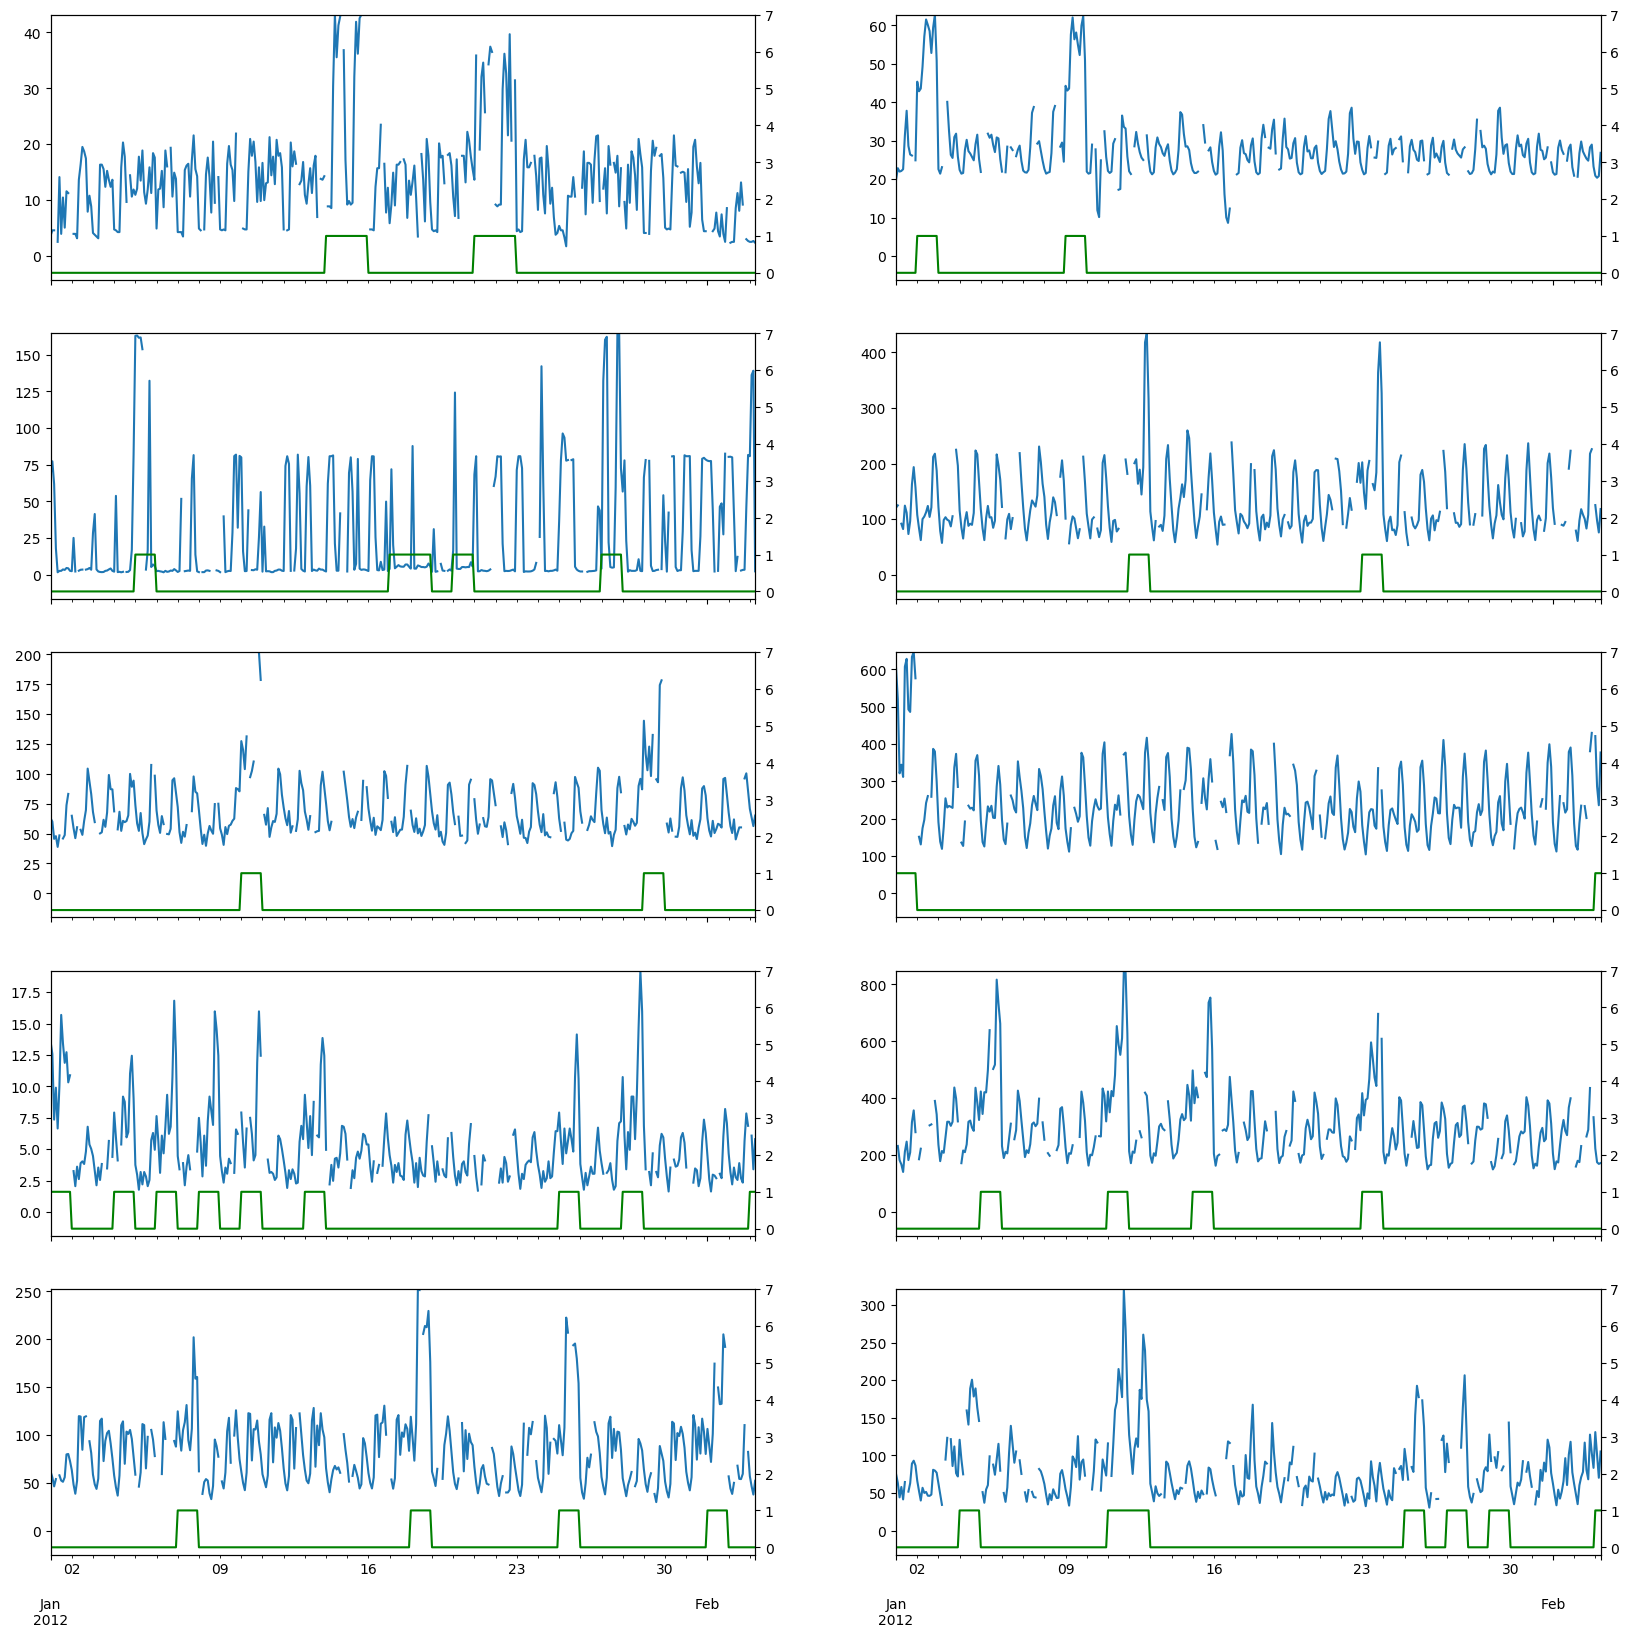

In [20]:

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ax = axx[i]
    ts = time_series_processed[i][:400]
    ts.plot(ax=ax)
    ax.set_ylim(-0.1 * ts.max(), ts.max())
    ax2 = ax.twinx()
    special_day_features[i][:400].plot(ax=ax2, color="g")
    ax2.set_ylim(-0.2, 7)

In [21]:
%%time

training_data_new_features = [
    {
        "start": str(start_dataset),
        "target": encode_target(ts[start_dataset:end_training]),
        "dynamic_feat": [special_day_features[i][start_dataset:end_training].tolist()],
    }
    for i, ts in enumerate(time_series_processed)
]
print(len(training_data_new_features))

# as in our previous example, we do a rolling evaluation over the next 7 days
num_test_windows = 7

test_data_new_features = [
    {
        "start": str(start_dataset),
        "target": encode_target(
            ts[start_dataset : end_training + 2 * k * prediction_length * ts.index.freq]
        ),
        "dynamic_feat": [
            special_day_features[i][
                start_dataset : end_training + 2 * k * prediction_length * ts.index.freq
            ].tolist()
        ],
    }
    for k in range(1, num_test_windows + 1)
    for i, ts in enumerate(timeseries_uplift)
]

370
CPU times: user 20.2 s, sys: 374 ms, total: 20.6 s
Wall time: 25.3 s


In [22]:
def check_dataset_consistency(train_dataset, test_dataset=None):
    d = train_dataset[0]
    has_dynamic_feat = "dynamic_feat" in d
    if has_dynamic_feat:
        num_dynamic_feat = len(d["dynamic_feat"])
    has_cat = "cat" in d
    if has_cat:
        num_cat = len(d["cat"])

    def check_ds(ds):
        for i, d in enumerate(ds):
            if has_dynamic_feat:
                assert "dynamic_feat" in d
                assert num_dynamic_feat == len(d["dynamic_feat"])
                for f in d["dynamic_feat"]:
                    assert len(d["target"]) == len(f)
            if has_cat:
                assert "cat" in d
                assert len(d["cat"]) == num_cat

    check_ds(train_dataset)
    if test_dataset is not None:
        check_ds(test_dataset)


check_dataset_consistency(training_data_new_features, test_data_new_features)

In [26]:
%%time
write_dicts_to_file("train_new_features.json", training_data_new_features)
write_dicts_to_file("test_new_features.json", test_data_new_features)

CPU times: user 10.8 s, sys: 586 ms, total: 11.4 s
Wall time: 15.1 s


In [30]:
%%time

s3_data_path_new_features = "s3://{}/{}-new-features/data".format(s3_bucket, s3_prefix)
s3_output_path_new_features = "s3://{}/{}-new-features/output".format(s3_bucket, s3_prefix)

print("Uploading to S3 this may take a few minutes depending on your connection.")
copy_to_s3(
    "train_new_features.json",
    s3_data_path_new_features + "/train/train_new_features.json",
    override=True,
)
copy_to_s3(
    "test_new_features.json",
    s3_data_path_new_features + "/test/test_new_features.json",
    override=True,
)

Uploading to S3 this may take a few minutes depending on your connection.
Uploading file to s3://sagemaker-us-east-1-772743166229/deepar-electricity-demo-notebook-new-features/data/train/train_new_features.json
Uploading file to s3://sagemaker-us-east-1-772743166229/deepar-electricity-demo-notebook-new-features/data/test/test_new_features.json
CPU times: user 796 ms, sys: 231 ms, total: 1.03 s
Wall time: 2.29 s


In [32]:
%%time
estimator_new_features = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.2xlarge",
    base_job_name="deepar-electricity-demo-new-features",
    output_path=s3_output_path_new_features,
    # By me:
    train_use_spot_instances = True,
    train_max_run = 1800,
    train_max_wait = 1800
)

# Me: I am changing the no. of epochs
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "epochs": "100",
    "learning_rate": "5E-4",
    "mini_batch_size": "64",
    "early_stopping_patience": "40",
    "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
}
estimator_new_features.set_hyperparameters(**hyperparameters)

estimator_new_features.fit(
    inputs={
        "train": "{}/train/".format(s3_data_path_new_features),
        "test": "{}/test/".format(s3_data_path_new_features),
    },
    wait=True,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: deepar-electricity-demo-new-features-2023-08-14-06-49-28-694


2023-08-14 06:49:28 Starting - Starting the training job...
2023-08-14 06:49:44 Starting - Preparing the instances for training......
2023-08-14 06:50:55 Downloading - Downloading input data...
2023-08-14 06:51:20 Training - Downloading the training image...
2023-08-14 06:51:51 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[08/14/2023 06:52:05 INFO 140493439403840] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '

### Deployment

In [34]:
%%time
predictor_new_features = estimator_new_features.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

INFO:sagemaker:Creating model with name: deepar-electricity-demo-new-features-2023-08-14-07-23-16-016
INFO:sagemaker:Creating endpoint-config with name deepar-electricity-demo-new-features-2023-08-14-07-23-16-016
INFO:sagemaker:Creating endpoint with name deepar-electricity-demo-new-features-2023-08-14-07-23-16-016


------!CPU times: user 70.1 ms, sys: 10.2 ms, total: 80.2 ms
Wall time: 3min 32s


In [55]:
customer_id = 120
predictor_new_features.predict(
    ts=time_series_processed[customer_id][:-prediction_length],
    dynamic_feat=[special_day_features[customer_id].tolist()],
    quantiles=[0.1, 0.5, 0.9],
).head()

,0.1,0.5,0.9
2014-12-25 02:00:00,200.940796,224.613541,243.856232
2014-12-25 04:00:00,187.298904,202.229813,226.713959
2014-12-25 06:00:00,180.415344,198.143921,213.898849
2014-12-25 08:00:00,228.046906,245.077469,262.126312
2014-12-25 10:00:00,227.576874,250.028900,275.060913


In [57]:
#rough
ts=time_series_processed[customer_id][:-prediction_length]
dynamic_feat=[special_day_features[customer_id].tolist()]

len(ts), len(dynamic_feat[0]) #(4141, 4225)

(4141, 4225)

In [ ]:
# Me: Run plot function from the first part

In [59]:
style = {"description_width": "initial"}

@interact_manual(
    customer_id=IntSlider(min=0, max=369, value=13, style=style),
    forecast_day=IntSlider(min=0, max=100, value=21, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    missing_ratio=FloatSlider(min=0.0, max=0.95, value=0.2, step=0.05, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False,
)
def plot_interact(customer_id, forecast_day, confidence, missing_ratio, show_samples):
    forecast_date = end_training + datetime.timedelta(days=forecast_day)
    ts = time_series_processed[customer_id]
    freq = ts.index.freq
    target = ts[start_dataset : forecast_date + prediction_length * freq]
    target = drop_at_random(target, missing_ratio)
    dynamic_feat = [
        special_day_features[customer_id][
            start_dataset : forecast_date + prediction_length * freq
        ].tolist()
    ]
    plot(
        predictor_new_features,
        target_ts=target,
        dynamic_feat=dynamic_feat,
        forecast_date=forecast_date,
        show_samples=show_samples,
        plot_history=7 * 12,
        confidence=confidence,
    )

interactive(children=(IntSlider(value=13, description='customer_id', max=369, style=SliderStyle(description_wi…

In [60]:
predictor_new_features.delete_model()

INFO:sagemaker:Deleting model with name: deepar-electricity-demo-new-features-2023-08-14-07-23-16-016


In [61]:
predictor_new_features.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: deepar-electricity-demo-new-features-2023-08-14-07-23-16-016
INFO:sagemaker:Deleting endpoint with name: deepar-electricity-demo-new-features-2023-08-14-07-23-16-016
